In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from metrics import get_summary, get_posterior_mean, get_neighbors, rotate_factors
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

In [2]:
import os
experiment_result = {}
for file in os.listdir("experiments"):
    if file.endswith(".pickle"):
        with open(f"experiments/{file}","rb") as f:
            data = pickle.load(f)
        f.close()
        experiment_result[file.split(".")[0]] = data

In [5]:
age = 25

X_samples = experiment_result["mixed_bpm,obpm,dbpm,stl,ast,blk,oreb,dreb,tov,ftm,fg2m,fg3m_2_rflvm"]["X"]
F_samples = experiment_result["mixed_bpm,obpm,dbpm,stl,ast,blk,oreb,dreb,tov,ftm,fg2m,fg3m_2_rflvm"]["F"]

rotated_X_samples = rotate_factors(X_samples.reshape(-1, X_samples.shape[2], X_samples.shape[3]))[0].reshape(X_samples.shape)

posterior_X_mean = get_posterior_mean(rotated_X_samples)






    




In [6]:
experiment_result.keys()

dict_keys(['mixed_bpm,obpm,dbpm,stl,ast,blk,oreb,dreb,tov,ftm,fg2m,fg3m_2_rflvm'])

In [7]:


pd.DataFrame(get_summary(rotated_X_samples), columns=["mean", "sd", "hdi_3%", "hdi_97%", "mcse_mean", "mcse_sd", "ess_bulk", "ess_tail", "r_hat"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,-2.116,0.028,-2.152,-2.078,0.018,0.015,3.0,29.0,1.81
1,0.875,0.016,0.872,0.877,0.001,0.001,3.0,32.0,1.81
2,-0.688,0.009,-0.698,-0.678,0.005,0.004,3.0,29.0,1.81
3,-0.438,0.001,-0.439,-0.437,0.000,0.000,3.0,32.0,1.81
4,-1.444,0.020,-1.470,-1.417,0.013,0.011,3.0,29.0,1.83
...,...,...,...,...,...,...,...,...,...
2035,0.445,0.007,0.444,0.445,0.000,0.000,3.0,32.0,1.81
2036,-1.573,0.020,-1.599,-1.546,0.013,0.011,3.0,29.0,1.81
2037,0.264,0.010,0.262,0.265,0.001,0.001,3.0,32.0,1.81
2038,-0.798,0.011,-0.812,-0.783,0.007,0.006,3.0,29.0,1.83


In [8]:


pd.DataFrame(get_summary(F_samples), columns=["mean", "sd", "hdi_3%", "hdi_97%", "mcse_mean", "mcse_sd", "ess_bulk", "ess_tail", "r_hat"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,0.001,0.009,-0.016,0.019,0.000,0.000,1851.0,1535.0,1.00
1,-0.001,0.009,-0.017,0.015,0.000,0.000,2193.0,1815.0,1.00
2,0.000,0.004,-0.007,0.008,0.000,0.000,1988.0,1885.0,1.00
3,-3.710,0.069,-3.823,-3.566,0.008,0.006,71.0,241.0,1.02
4,-3.286,0.137,-3.531,-3.031,0.022,0.015,42.0,150.0,1.01
...,...,...,...,...,...,...,...,...,...
12235,-1.993,0.101,-2.146,-1.806,0.036,0.026,9.0,142.0,1.20
12236,-2.877,0.143,-3.132,-2.671,0.084,0.066,4.0,52.0,1.54
12237,1.204,0.081,1.058,1.359,0.005,0.003,304.0,392.0,1.02
12238,-0.057,0.035,-0.117,0.011,0.003,0.002,122.0,181.0,1.04


In [9]:
df = pd.read_csv("datasets/player_data.csv")
df = df.sort_values(by=["id","year"])

### nearest neighbors
print(get_neighbors(df, "Stephen Curry", 6, posterior_X_mean, query = f"age == {age} and minutes > 0"))
print(get_neighbors(df, "Tim Duncan", 6, posterior_X_mean, query = f"age == {age} and minutes > 0"))
print(get_neighbors(df, "Kevin Durant", 6, posterior_X_mean, query = f"age == {age} and minutes > 0"))
print(get_neighbors(df, "Klay Thompson", 6, posterior_X_mean, query = f"age == {age} and minutes > 0"))


624    Stephen Curry
216      Baron Davis
46          Bob Sura
518      Rajon Rondo
221     Andre Miller
658    Nando De Colo
Name: name, dtype: object
128          Tim Duncan
753       Anthony Davis
426          Josh Smith
941       Pascal Siakam
297           Pau Gasol
232    Andrei Kirilenko
Name: name, dtype: object
539    Kevin Durant
21       Grant Hill
370     Dwyane Wade
621    James Harden
366    LeBron James
134      Tim Thomas
Name: name, dtype: object
718    Klay Thompson
262    Keyon Dooling
121     Matt Maloney
181       Bryce Drew
361     Smush Parker
977     Monte Morris
Name: name, dtype: object


In [10]:
import plotly.express as px
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_scatter(dataframe, rotated_means_dict, metric, model, offset = "minutes", mixed_metric_index = 0, mixed_metric_model = "binomial", mixed_metric_offset = "minutes", chain=1):

    key_name = f"{model}_{metric}_{chain}_rflvm"
    
    if model != "mixed":
        df_size_vals = dataframe[[offset,"id"]].groupby("id").mean().reset_index()
        df_names = dataframe[["id","name"]].drop_duplicates()["name"].values
        data = pd.DataFrame(rotated_means_dict[key_name], columns=["x","y"])
        data["names"] = df_names
        data[offset] = df_size_vals[offset]
    else:
        df_names = dataframe[(dataframe["age"] == 25) & (dataframe["minutes"] > 0)][["id","name"]].drop_duplicates()["name"].values
        metric_list = metric.split(",")
        exposure_list = mixed_metric_offset.split(",")
        metric_df = dataframe[(dataframe["age"] == 25) & (dataframe["minutes"] > 0)][metric_list + ["id"]]
        exposure_df = dataframe[(dataframe["age"] == 25) & (dataframe["minutes"] > 0)][exposure_list + ["id"]]
        player_id_df = dataframe[(dataframe["age"] == 25) & (dataframe["minutes"] > 0)][["id"]].drop_duplicates()
        data = pd.merge(metric_df, player_id_df, on ="id", how = "right")[metric_list].fillna(0)
        offset_data = pd.merge(exposure_df, player_id_df, on ="id", how = "right").iloc[:, 0:len(exposure_list)].fillna(0)

    if model == "binomial":
        df_color_vals = dataframe[[metric,offset, "id"]].groupby("id").sum().reset_index()
        data[f"{metric}_pct"] = df_color_vals[metric]/df_color_vals[offset]
        fig = px.scatter(data_frame= data,   
                   x = "x", y = "y", hover_data = [f"{metric}_pct",offset,"names"], title = metric, size = offset,
                         color = f"{metric}_pct", range_color = [.1,.7])
    elif model == "poisson":
        df_color_vals = dataframe[[metric,offset,"id"]].groupby("id").sum().reset_index()
        data[f"{metric}_rate"] = df_color_vals[metric]/df_color_vals[offset]
        fig = px.scatter(data_frame = data, x = "x", y = "y", hover_data = [f"{metric}_rate",offset,"names"], 
                         title = metric, size = offset,
                         color = f"{metric}_rate", range_color = [0,.1])
    elif model == "gaussian":
        df_color_vals = dataframe[[metric, "id"]].groupby("id").mean().reset_index()
        data["hover"] = df_color_vals[metric]
        fig = px.scatter(data_frame = data, x = "x", y = "y", color = "hover",
                    size = offset, hover_data = ["hover",offset,"names"], title = metric )
    elif model == "mixed":
        metrics = metric.split(",")
        metric = metrics[mixed_metric_index]
        offset = mixed_metric_offset.split(",")[mixed_metric_index]
        new_df = pd.DataFrame(rotated_means_dict[key_name]["X"][0].mean(axis=0).T, columns=["x","y"])
        new_df["names"] = df_names
        if mixed_metric_model == "binomial":
            new_df[f"{metric}_pct"] = data.iloc[:, mixed_metric_index]/offset_data.iloc[:, mixed_metric_index]
            new_df[offset] = offset_data.iloc[:, mixed_metric_index]
            fig = px.scatter(data_frame= new_df,   
                    x = "x", y = "y", hover_data = [f"{metric}_pct",offset,"names"], title = metric, size = offset,
                            color = f"{metric}_pct", range_color = [.1,.7])
        elif mixed_metric_model == "poisson":
            new_df[f"{metric}_rate"] = data.iloc[:, mixed_metric_index]/offset_data.iloc[:, mixed_metric_index]
            new_df[offset] = offset_data.iloc[:, mixed_metric_index]
            fig = px.scatter(data_frame = new_df, x = "x", y = "y", hover_data = [f"{metric}_rate",offset,"names"], 
                            title = metric, size = offset,
                            color = f"{metric}_rate", range_color = [0,.1])
        elif mixed_metric_model == "gaussian":
            new_df[f"{metric}"] = data.iloc[:, mixed_metric_index]
            new_df[offset] = np.sqrt(offset_data.iloc[:, mixed_metric_index])
            fig = px.scatter(data_frame = new_df, x = "x", y = "y", color = metric,
                        size = offset, hover_data = [metric,offset,"names"], title = metric, range_color = [0,10] )
    
    fig.show()
    

def plot_heatmap(K, labels):
    dissimilarity = np.around(1 - np.abs(K), decimals = 10)
    hierarchy = linkage(dissimilarity, method='complete')
    order = leaves_list(hierarchy)
    reordered_matrix = dissimilarity[:, order]
    reordered_matrix = reordered_matrix[order, :]
    fig = px.imshow(1 - reordered_matrix, x=labels[order], y=labels[order], labels=dict(x='X-axis', y='Y-axis'))
    # Configure the layout
    fig.update_layout(title='Correlation of Latent Space')

    # Enable hover information
    fig.update_traces(hovertemplate='x: %{x}<br>y: %{y}')

    # Enable zooming functionality
    fig.update_layout(
    hovermode='x unified',
    hoverdistance=1,
    )

    # Show the interactive heatmap
    fig.show()
       


In [11]:

from scipy.spatial import KDTree
def plot_trajectories(data_frame, player, num_k, metric, latent_space):
    name_map = data_frame[["id","name"]].drop_duplicates().reset_index()[["id","name"]]
    player_index = name_map.index[name_map["name"] == player][0]
    point = latent_space[player_index,:]
    _, indices = KDTree(latent_space).query(point, k = num_k)
    nearest_neighbors_names = name_map.loc[indices]["name"]
    trajectory_df = data_frame[data_frame["name"].isin(nearest_neighbors_names)][["name",metric,"age"]]
    fig = px.line(trajectory_df, x='age', y=metric, color='name', labels={metric: metric, 'name': 'Player'})
    fig.update_layout(title=f'{metric} over time for {num_k -1} neighbors of {player}')
    fig.show()



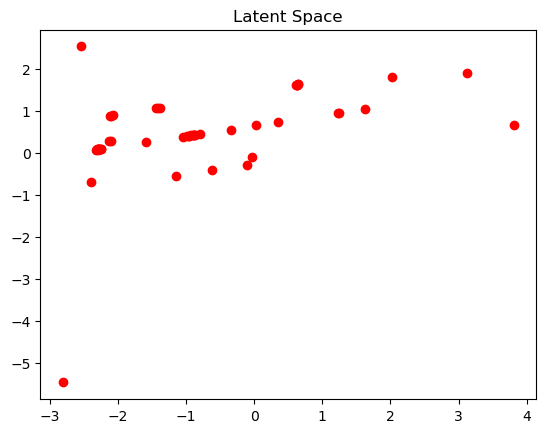

In [12]:
from adjustText import adjust_text
import random
frac = .05
labels = df.query(f"age == {age} and minutes > 0")["name"].tolist()

n_samples = int(frac * posterior_X_mean.shape[0])
random_indices = random.sample(range(posterior_X_mean.shape[0]), n_samples)
plt.scatter(posterior_X_mean[random_indices, 0], posterior_X_mean[random_indices, 1], c="r")
# texts = [plt.text(posterior_X_mean[i,0], posterior_X_mean[i,1], labels[i], ha='center', va='center') for i in random_indices]
# Adjust the text positions to avoid overlap
# adjust_text(texts)
plt.title("Latent Space")
plt.show()

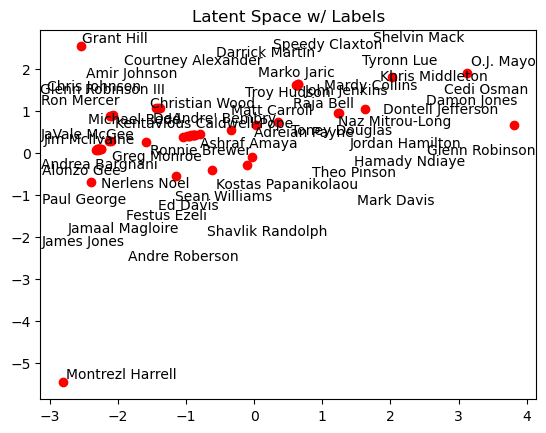

In [13]:
plt.scatter(posterior_X_mean[random_indices, 0], posterior_X_mean[random_indices, 1], c="r")
texts = [plt.text(posterior_X_mean[i,0], posterior_X_mean[i,1], labels[i], ha='center', va='center') for i in random_indices]
# Adjust the text positions to avoid overlap
adjust_text(texts)
plt.title("Latent Space w/ Labels")
plt.show()